<a href="https://colab.research.google.com/github/carlomagnani/Stock-Price-Forecaster/blob/main/SP500_Trend_Forecast_daily_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

print("Tensorflow version: "+tf.__version__)

#! pip install pmdarima

# Google file system
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

drive.mount('/GoogleDrive', force_remount=True)

import math

file =   "/GoogleDrive/My Drive/S&P.xlsx"
dataset = pd.read_excel(file, sheet_name="ts")

Tensorflow version: 2.8.0
Mounted at /GoogleDrive


In [3]:
#Date to Datetime for Plotting
dataset['date'] = pd.to_datetime(dataset['date'])

#Returns
dataset['log_value'] = np.log(dataset['time'])
dataset['log_ret'] = dataset['log_value'] - dataset['log_value'].shift(+1)
dataset['lead_ret'] = dataset['log_ret'].shift(-1)
dataset['lead_weekly_ret'] = dataset['log_ret'].rolling(5).sum().shift(-5)
dataset['lag_weekly_ret'] = dataset['log_ret'].rolling(5).sum()

#Returns Classes
dataset['log_ret_class'] = np.where(dataset['log_ret']>0,1,0) #Log Return Class
dataset['lag_weekly_ret_class'] = np.where(dataset['lag_weekly_ret']>0,1,0) #T to T-5 Return Class
dataset['lead_weekly_ret_class'] = np.where(dataset['lead_weekly_ret']> 0, 1, 0) #Target Class
dataset['lead_ret_class'] = np.where(dataset['lead_ret']> 0, 1, 0) #Next Day Return Class

#Simple Moving Averages
dataset['sma_3'] = dataset['log_value'].rolling(3).mean()
dataset['sma_5'] = dataset['log_value'].rolling(5).mean()
dataset['sma_10'] = dataset['log_value'].rolling(10).mean()
dataset['sma_20'] = dataset['log_value'].rolling(20).mean()
dataset['sma_50'] = dataset['log_value'].rolling(50).mean()
dataset['sma_100'] = dataset['log_value'].rolling(100).mean()
dataset['sma_200'] = dataset['log_value'].rolling(200).mean()

#Exponentially Weighted Variance 
dataset['sq_ret'] = np.power(dataset['log_ret'],2)
dataset['ewma_var'] = dataset['sq_ret'].ewm(alpha = 0.96).mean() #Uses the RiskMetrics 0.96 decay factor

#Exponentially Weighted Moving Averages
dataset['ema_200'] = dataset['log_value'].ewm(alpha = 0.01).mean()
dataset['ema_50'] = dataset['log_value'].ewm(alpha = 0.0392).mean()
dataset['ema_10'] = dataset['log_value'].ewm(alpha = 0.181).mean()
dataset['ema_3'] = dataset['log_value'].ewm(alpha = 0.5).mean()

#Drop Time and NAs
dataset.pop('time')

dataset.dropna(inplace = True)

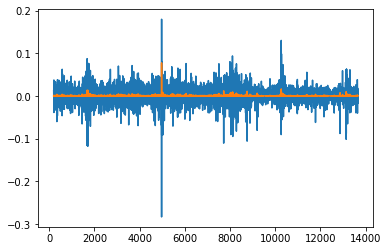

In [46]:
#Some Plotting to check variables
#plt.plot(dataset['log_value'])
#plt.plot(dataset['ma_3'])
#plt.plot(dataset['ma_20'])
plt.plot(dataset['log_ret'])
plt.plot(dataset['ewma_var'])

In [4]:
#Signal Generation

#Momentum Rule
dataset['momentum_120'] = dataset['log_value'] - dataset['log_value'].shift(+200)
dataset['momentum_121'] = dataset['log_value'].shift(+20) - dataset['log_value'].shift(+200)
dataset['momentum_61'] = dataset['log_value'].shift(+20) - dataset['log_value'].shift(+100)

dataset['mom_120_rule'] = np.where(dataset['momentum_120']> 0, 1, 0)
dataset['mom_121_rule'] = np.where(dataset['momentum_121']> 0, 1, 0)
dataset['mom_61_rule'] = np.where(dataset['momentum_61']> 0, 1, 0)

#MA Change of Direction Rule

dataset['ma_200_cd_rule'] = np.where((dataset['sma_200']- dataset['sma_200'].shift(+1))>0,1,0)
dataset['ma_20_cd_rule'] = np.where((dataset['sma_20']- dataset['sma_20'].shift(+1))>0,1,0)

#PMA Rule

dataset['pma_20'] = dataset['log_value'] - dataset['sma_20']      
dataset['pma_100'] = dataset['log_value'] - dataset['sma_100']
dataset['pma_200'] = dataset['log_value'] - dataset['sma_200']

dataset['pma_20_rule'] = np.where(dataset['pma_20']>0, 1, 0)
dataset['pma_100_rule'] = np.where(dataset['pma_100']>0, 1, 0)
dataset['pma_200_rule'] = np.where(dataset['pma_200']>0, 1, 0)

#MA Crossover Rule

dataset['mac_3_10'] = dataset['sma_3'] - dataset['sma_10']
dataset['mac_50_200'] = dataset['sma_50'] - dataset['sma_200']

dataset['mac_3_10_rule'] = np.where(dataset['mac_3_10']>0, 1, 0)
dataset['mac_50_200_rule'] = np.where(dataset['mac_50_200']>0, 1, 0)

#Ma Convergence/Divergence Rule

dataset['mac_ema_50_200'] = dataset['ema_50'] - dataset['ema_200']

dataset['ema_mac_50_200'] = dataset['mac_ema_50_200'].ewm(alpha = 0.095).mean()

dataset['macd_50_200'] = dataset['mac_ema_50_200'] - dataset['ema_mac_50_200']

dataset['macd_50_200_rule'] = np.where(dataset['macd_50_200']>0, 1, 0)

In [5]:
rule_cols = [col for col in dataset.columns if 'rule' in col]

col_names = ['log_ret_class', 'lag_weekly_ret_class', 'ewma_var']

var_name = ['lead_ret_class']

col_names =  var_name + col_names + rule_cols

#var_name = ['lead_weekly_ret_class']

print(col_names)

model_df = dataset[col_names]

model_df.dropna(inplace = True)

model_df


['lead_ret_class', 'log_ret_class', 'lag_weekly_ret_class', 'ewma_var', 'mom_120_rule', 'mom_121_rule', 'mom_61_rule', 'ma_200_cd_rule', 'ma_20_cd_rule', 'pma_20_rule', 'pma_100_rule', 'pma_200_rule', 'mac_3_10_rule', 'mac_50_200_rule', 'macd_50_200_rule']


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,lead_ret_class,log_ret_class,lag_weekly_ret_class,ewma_var,mom_120_rule,mom_121_rule,mom_61_rule,ma_200_cd_rule,ma_20_cd_rule,pma_20_rule,pma_100_rule,pma_200_rule,mac_3_10_rule,mac_50_200_rule,macd_50_200_rule
199,1,1,1,0.000012,0,0,0,0,0,1,1,1,1,1,0
200,1,1,1,0.000010,0,0,0,1,1,1,1,1,1,1,1
201,1,1,1,0.000005,0,0,0,1,1,1,1,1,1,1,1
202,0,1,1,0.000029,0,0,0,1,1,1,1,1,1,1,1
203,1,0,1,0.000046,0,0,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23652,0,1,1,0.000479,1,1,1,1,1,0,0,0,0,1,0
23653,0,0,1,0.000025,1,1,1,1,0,0,0,0,0,1,0
23654,1,0,1,0.000234,1,1,1,1,0,0,0,0,0,1,0
23655,0,1,1,0.000337,1,1,1,1,0,0,0,0,1,1,0


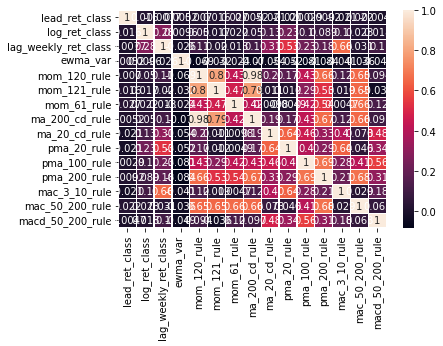

In [49]:
#Correlation Matrix

import seaborn as sn

corr_mat = model_df.corr()
sn.heatmap(corr_mat, annot=True, linewidths=.3)
plt.show()

In [8]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

#prepare Train-Test-Validate Dataset

steps = 20

ts = 0.1

values = model_df.values

# Creating a data structure with i time-steps and 1 output
X = []
y = []

for i in range(steps, len(values)):
    X.append(values[i-steps:i, 1:])
    y.append(values[i, 0])

X, y = np.array(X), np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

y = np.reshape(y, (y.shape[0],1))

# Creating a data structure with i time-steps and 1 output
train_X = []
train_y = []

test_X = []
test_y = []

validation_X = []
validation_y = []

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

train_X, validation_X, train_y, validation_y = train_test_split(train_X, train_y, test_size= ts, random_state=1) # 0.02 x 0.8 = 0.016

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, validation_X.shape, validation_y.shape)

(16875, 20, 14) (16875, 1) (4688, 20, 14) (4688, 1) (1875, 20, 14) (1875, 1)


In [ ]:
#Other Train Dev Test Set, with week ahead class and using last year as validation to see effects from Overfitting

In [ ]:
train_y

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

Epoch 1/100
528/528 - 8s - loss: 0.6937 - accuracy: 0.5160 - val_loss: 0.6902 - val_accuracy: 0.5350 - 8s/epoch - 15ms/step
Epoch 2/100
528/528 - 3s - loss: 0.6925 - accuracy: 0.5175 - val_loss: 0.6900 - val_accuracy: 0.5369 - 3s/epoch - 6ms/step
Epoch 3/100
528/528 - 3s - loss: 0.6923 - accuracy: 0.5245 - val_loss: 0.6900 - val_accuracy: 0.5429 - 3s/epoch - 6ms/step
Epoch 4/100
528/528 - 3s - loss: 0.6920 - accuracy: 0.5248 - val_loss: 0.6898 - val_accuracy: 0.5339 - 3s/epoch - 6ms/step
Epoch 5/100
528/528 - 3s - loss: 0.6919 - accuracy: 0.5260 - val_loss: 0.6898 - val_accuracy: 0.5343 - 3s/epoch - 6ms/step
Epoch 6/100
528/528 - 3s - loss: 0.6917 - accuracy: 0.5258 - val_loss: 0.6899 - val_accuracy: 0.5341 - 3s/epoch - 6ms/step
Epoch 7/100
528/528 - 3s - loss: 0.6914 - accuracy: 0.5271 - val_loss: 0.6898 - val_accuracy: 0.5356 - 3s/epoch - 6ms/step
Epoch 8/100
528/528 - 3s - loss: 0.6913 - accuracy: 0.5285 - val_loss: 0.6897 - val_accuracy: 0.5337 - 3s/epoch - 6ms/step
Epoch 9/100
528

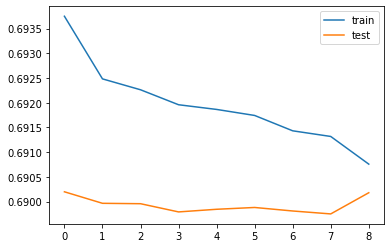

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience = 8, min_delta=0.001)

model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))

#Additional layers we researched and then didn't use due to poor performance
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(units = 1, activation = 'sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [tf.keras.metrics.Recall()])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')
# fit network
history = model.fit(train_X, train_y, epochs = 100, batch_size=32, validation_data = (test_X, test_y), verbose=2, shuffle=False, callbacks=[early_stopping])

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

yhat = (model.predict(test_X) > 0.5).astype("int32")

yhat = yhat.reshape(yhat.shape[0],yhat.shape[1])

test_y = test_y.reshape(test_y.shape[0],1)

print(confusion_matrix(pd.DataFrame(test_y).iloc[:,0], pd.DataFrame(yhat).iloc[:,0]))
#print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
#print(classification_report(pd.DataFrame(test_y).iloc[:,0], pd.DataFrame(yhat).iloc[:,0], target_names = ['1', '0']))
print(classification_report(pd.DataFrame(test_y).iloc[:,0], pd.DataFrame(yhat).iloc[:,0]))


#print(yhat, validation_y)

[[ 155 2029]
 [ 145 2359]]
              precision    recall  f1-score   support

         0.0       0.52      0.07      0.12      2184
         1.0       0.54      0.94      0.68      2504

    accuracy                           0.54      4688
   macro avg       0.53      0.51      0.40      4688
weighted avg       0.53      0.54      0.42      4688



In [13]:
#Import Random Forest and Train_Test Split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

train_rf_X = train_X[:,0,1:]

test_rf_X = test_X[:,0,1:]

train_rf_y = train_y[:,0]

test_rf_y = test_y[:,0]

#validation_rf_X = validation_X[:,0,1:]

#validation_rf_y = validation_y[:,0,0]

print(train_rf_X.shape, train_rf_y.shape, test_rf_X.shape, test_rf_y.shape)

#, test_rf_X, train_rf_y, test_rf_y = 

#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_rf_X,train_rf_y)

y_pred = clf.predict(test_rf_X)

#y_val = clf.predict(validation_rf_X)

from sklearn import metrics

#test metrics

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_pred).iloc[:,0]))

#validation metrics
#print(confusion_matrix(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0]))

#print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0], target_names = ['0', '1']))


(16875, 13) (16875,) (4688, 13) (4688,)
[[ 973 1211]
 [1088 1416]]
              precision    recall  f1-score   support

         0.0       0.47      0.45      0.46      2184
         1.0       0.54      0.57      0.55      2504

    accuracy                           0.51      4688
   macro avg       0.51      0.51      0.51      4688
weighted avg       0.51      0.51      0.51      4688



In [14]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)

clf_gb.fit(train_rf_X,train_rf_y)

y_gb_pred = clf_gb.predict(test_rf_X)

#y_val = clf_gb.predict(validation_rf_X)

#test metrics

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_gb_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_gb_pred).iloc[:,0]))

#validation metrics

#print(confusion_matrix(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0]))

#print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0], target_names = ['0', '1']))




[[ 386 1798]
 [ 378 2126]]
              precision    recall  f1-score   support

         0.0       0.51      0.18      0.26      2184
         1.0       0.54      0.85      0.66      2504

    accuracy                           0.54      4688
   macro avg       0.52      0.51      0.46      4688
weighted avg       0.52      0.54      0.48      4688



In [15]:
from sklearn import svm

clf_svm = svm.NuSVC(gamma="auto")

clf_svm.fit(train_rf_X,train_rf_y)

y_svm_pred = clf_svm.predict(test_rf_X)

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_svm_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_svm_pred).iloc[:,0]))


[[1211  973]
 [1424 1080]]
              precision    recall  f1-score   support

         0.0       0.46      0.55      0.50      2184
         1.0       0.53      0.43      0.47      2504

    accuracy                           0.49      4688
   macro avg       0.49      0.49      0.49      4688
weighted avg       0.50      0.49      0.49      4688



In [16]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state = 1, penalty = 'l2')

clf_lr.fit(train_rf_X,train_rf_y)

y_lr_pred = clf_lr.predict(test_rf_X)

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_lr_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_lr_pred).iloc[:,0]))

[[ 466 1718]
 [ 481 2023]]
              precision    recall  f1-score   support

         0.0       0.49      0.21      0.30      2184
         1.0       0.54      0.81      0.65      2504

    accuracy                           0.53      4688
   macro avg       0.52      0.51      0.47      4688
weighted avg       0.52      0.53      0.48      4688



Epoch 1/100
528/528 - 2s - loss: 0.6958 - accuracy: 0.5058 - val_loss: 0.6904 - val_accuracy: 0.5333 - 2s/epoch - 4ms/step
Epoch 2/100
528/528 - 1s - loss: 0.6925 - accuracy: 0.5161 - val_loss: 0.6902 - val_accuracy: 0.5354 - 1s/epoch - 2ms/step
Epoch 3/100
528/528 - 1s - loss: 0.6924 - accuracy: 0.5211 - val_loss: 0.6906 - val_accuracy: 0.5318 - 1s/epoch - 2ms/step
Epoch 4/100
528/528 - 1s - loss: 0.6921 - accuracy: 0.5215 - val_loss: 0.6910 - val_accuracy: 0.5297 - 1s/epoch - 2ms/step
Epoch 5/100
528/528 - 1s - loss: 0.6922 - accuracy: 0.5220 - val_loss: 0.6902 - val_accuracy: 0.5314 - 1s/epoch - 2ms/step
Epoch 6/100
528/528 - 1s - loss: 0.6920 - accuracy: 0.5220 - val_loss: 0.6909 - val_accuracy: 0.5328 - 1s/epoch - 2ms/step
Epoch 7/100
528/528 - 1s - loss: 0.6919 - accuracy: 0.5225 - val_loss: 0.6909 - val_accuracy: 0.5320 - 1s/epoch - 2ms/step
Epoch 8/100
528/528 - 1s - loss: 0.6918 - accuracy: 0.5266 - val_loss: 0.6913 - val_accuracy: 0.5337 - 1s/epoch - 2ms/step
Epoch 9/100
528/

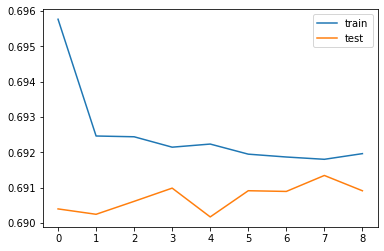

In [17]:
#from tensorflow.keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

model_mlp = Sequential()

early_stopping = EarlyStopping(monitor='val_loss', patience = 8, min_delta=0.001)

#train_rf_X = np.reshape(train_rf_X, (train_rf_X.shape[0], train_rf_X.shape[1], train_rf_X.shape[2]))

#train_rf_y = np.reshape(train_rf_y, (train_rf_y.shape[0],1))

model_mlp.add(Dense(100, input_shape=(train_rf_X.shape[1],), activation = 'relu'))
model_mlp.add(Dropout(0.3))

#Additional layers we researched and then didn't use due to poor performance
model_mlp.add(Dense(100, activation = 'relu'))
model_mlp.add(Dropout(0.3))

model_mlp.add(Dense(100, activation = 'relu'))
model_mlp.add(Dropout(0.3))

model_mlp.add(Dense(units = 1, activation = 'sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [tf.keras.metrics.Recall()])
model_mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')
# fit network
history_mlp = model_mlp.fit(train_rf_X, train_rf_y, epochs = 100, batch_size=32, validation_data = (test_rf_X, test_rf_y), verbose=2, shuffle=False, callbacks=[early_stopping])

# plot history
plt.plot(history_mlp.history['loss'], label='train')
plt.plot(history_mlp.history['val_loss'], label='test')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

yhat_mlp = (model_mlp.predict(test_rf_X) > 0.5).astype("int32")

yhat_mlp = yhat_mlp.reshape(yhat_mlp.shape[0],yhat_mlp.shape[1])

test_rf_y = test_rf_y.reshape(test_rf_y.shape[0],1)

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(yhat_mlp).iloc[:,0]))
#print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(yhat_mlp).iloc[:,0]))

#print(yhat, validation_y)

[[  76 2108]
 [  69 2435]]
              precision    recall  f1-score   support

         0.0       0.52      0.03      0.07      2184
         1.0       0.54      0.97      0.69      2504

    accuracy                           0.54      4688
   macro avg       0.53      0.50      0.38      4688
weighted avg       0.53      0.54      0.40      4688



In [31]:
# Model 2 Development

validation_rf_X = validation_X[:,0,1:]

validation_rf_y = validation_y[:,0]

print(validation_rf_X.shape, validation_rf_y.shape)

#LSTM
yhat_test = (model.predict(validation_X) > 0.5).astype("int32")

yhat_test = yhat_test.reshape(yhat_test.shape[0],yhat_test.shape[1])

validation_y = validation_y.reshape(validation_y.shape[0],1)

#Random Forest

y_pred_test = clf.predict(validation_rf_X)

#Gradient Boosting

y_gb_pred_test = clf_gb.predict(validation_rf_X)

#Support Vector Classifier

y_svm_pred_test = clf_svm.predict(validation_rf_X)

#Logistic Regression

y_lr_pred_test = clf_lr.predict(validation_rf_X)

#Multi Layer Perceptron

y_mlp_pred_test = (model_mlp.predict(validation_rf_X) > 0.5).astype("int32")

print(y_mlp_pred_test.shape)

y_mlp_pred_test = y_mlp_pred_test.reshape(y_mlp_pred_test.shape[0],y_mlp_pred_test.shape[1])


(1875, 13) (1875,)
(1875, 1)


In [32]:
print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(yhat_test).iloc[:,0]))


              precision    recall  f1-score   support

         0.0       0.57      0.08      0.13       915
         1.0       0.52      0.94      0.67       960

    accuracy                           0.52      1875
   macro avg       0.54      0.51      0.40      1875
weighted avg       0.54      0.52      0.41      1875



In [34]:
#Model 2 Train Set

model_stack = pd.DataFrame(yhat, columns = ['lstm'])

model_stack['mlp'] = yhat_mlp

model_stack['randomForest'] = y_pred

model_stack['GradientBoosting'] = y_gb_pred

model_stack['svm'] = y_svm_pred

model_stack['logReg'] = y_lr_pred

X_stack = np.concatenate((model_stack.values,test_rf_X),axis=1)

print(X_stack.shape)


(4688, 19)


In [36]:
#Model 2 Train Set

model_test_stack = pd.DataFrame(yhat_test, columns = ['lstm'])

model_test_stack['mlp'] = y_mlp_pred_test

model_test_stack['randomForest'] = y_pred_test

model_test_stack['GradientBoosting'] = y_gb_pred_test

model_test_stack['svm'] = y_svm_pred_test

model_test_stack['logReg'] = y_lr_pred_test

X_test_stack = np.concatenate((model_test_stack.values,validation_rf_X),axis=1)

In [36]:
X_test_stack.shape

(376, 19)

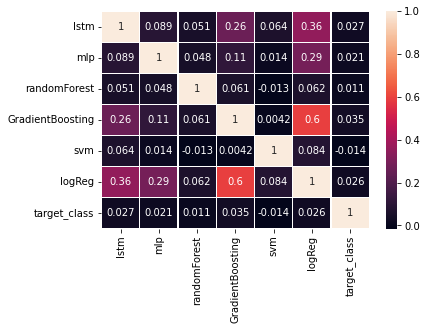

In [35]:
#Correlation Matrix

import seaborn as sn

model_corr = model_stack

model_corr['target_class'] = test_rf_y

corr_mat = model_corr.corr()
sn.heatmap(corr_mat, annot=True, linewidths=.3)
plt.show()

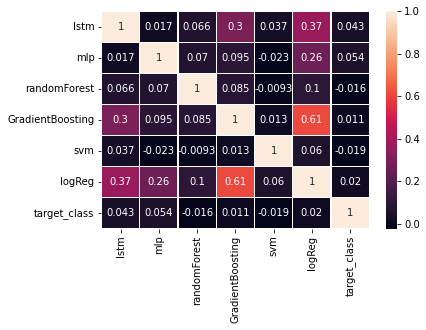

In [37]:
#Correlation Matrix

import seaborn as sn

model_corr = model_test_stack

model_corr['target_class'] = validation_rf_y

corr_mat = model_corr.corr()
sn.heatmap(corr_mat, annot=True, linewidths=.3)
plt.show()

Epoch 1/100
147/147 - 1s - loss: 0.6986 - accuracy: 0.5188 - val_loss: 0.6932 - val_accuracy: 0.5131 - 1s/epoch - 7ms/step
Epoch 2/100
147/147 - 0s - loss: 0.6919 - accuracy: 0.5220 - val_loss: 0.6947 - val_accuracy: 0.5120 - 401ms/epoch - 3ms/step
Epoch 3/100
147/147 - 0s - loss: 0.6914 - accuracy: 0.5265 - val_loss: 0.6930 - val_accuracy: 0.5163 - 445ms/epoch - 3ms/step
Epoch 4/100
147/147 - 0s - loss: 0.6898 - accuracy: 0.5346 - val_loss: 0.6930 - val_accuracy: 0.5173 - 411ms/epoch - 3ms/step
Epoch 5/100
147/147 - 0s - loss: 0.6896 - accuracy: 0.5331 - val_loss: 0.6931 - val_accuracy: 0.5136 - 404ms/epoch - 3ms/step
Epoch 6/100
147/147 - 0s - loss: 0.6881 - accuracy: 0.5388 - val_loss: 0.6950 - val_accuracy: 0.5152 - 399ms/epoch - 3ms/step
Epoch 7/100
147/147 - 0s - loss: 0.6886 - accuracy: 0.5395 - val_loss: 0.6946 - val_accuracy: 0.5211 - 404ms/epoch - 3ms/step
Epoch 8/100
147/147 - 0s - loss: 0.6867 - accuracy: 0.5427 - val_loss: 0.6950 - val_accuracy: 0.5152 - 423ms/epoch - 3ms/

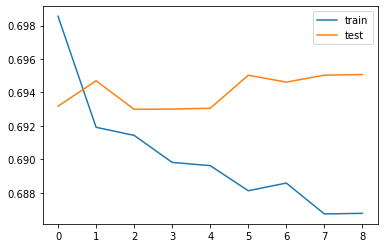

In [39]:
model_stacked = Sequential()

early_stopping = EarlyStopping(monitor='val_loss', patience = 8, min_delta=0.001)

#train_rf_X = np.reshape(train_rf_X, (train_rf_X.shape[0], train_rf_X.shape[1], train_rf_X.shape[2]))

#train_rf_y = np.reshape(train_rf_y, (train_rf_y.shape[0],1))

model_stacked.add(Dense(1000, input_shape=(X_stack.shape[1],), activation = 'relu'))
model_stacked.add(Dropout(0.3))

#Additional layers we researched and then didn't use due to poor performance
model_stacked.add(Dense(1000, activation = 'relu'))
model_stacked.add(Dropout(0.3))

model_stacked.add(Dense(1000, activation = 'relu'))
model_stacked.add(Dropout(0.3))

model_stacked.add(Dense(units = 1, activation = 'sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [tf.keras.metrics.Recall()])
model_stacked.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')
# fit network
history_stacked = model_stacked.fit(X_stack, test_rf_y, epochs = 100, batch_size=32, validation_data = (X_test_stack, validation_rf_y), verbose=2, shuffle=False, callbacks=[early_stopping])
#history_stacked = model_stacked.fit(X_stack, test_rf_y, epochs = 50, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stopping])

# plot history
plt.plot(history_stacked.history['loss'], label='train')
plt.plot(history_stacked.history['val_loss'], label='test')
plt.legend()
plt.show()

In [41]:
#Gradient Boosting as Stacking Algorithm

stk_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)

stk_gb.fit(X_stack, test_rf_y)

stck_gb_pred = stk_gb.predict(X_test_stack)

#y_val = clf_gb.predict(validation_rf_X)

#test metrics

#print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_gb_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(stck_gb_pred).iloc[:,0]))

#validation metrics

#print(confusion_matrix(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0]))

#print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0], target_names = ['0', '1']))





/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         0.0       0.54      0.19      0.28       915
         1.0       0.52      0.85      0.65       960

    accuracy                           0.53      1875
   macro avg       0.53      0.52      0.46      1875
weighted avg       0.53      0.53      0.47      1875



In [43]:
# Logistic Regression as Stacking Classifier


stk_lr = LogisticRegression(random_state = 1, penalty = 'l2')

stk_lr.fit(X_stack, test_rf_y)

stk_lr_pred = stk_lr.predict(X_test_stack)

#print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_lr_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(stk_lr_pred).iloc[:,0]))

              precision    recall  f1-score   support

         0.0       0.55      0.19      0.28       915
         1.0       0.52      0.85      0.65       960

    accuracy                           0.53      1875
   macro avg       0.54      0.52      0.47      1875
weighted avg       0.54      0.53      0.47      1875



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
